In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn import preprocessing
from diffusers import UNet1DModel, DDPMScheduler, DDIMScheduler
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F

/home/arpydarpy/miniconda3/envs/a1nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_rms(records, multi_channels):
    if multi_channels == 1:
        n = records.shape[0]
        rms = 0
        for i in range(n):
            rms_t = np.sum([records[i]**2]/len(records[i]))
            rms += rms_t
        return rms/n
    
    if multi_channels == 0:
        rms = np.sum([records**2])/ len(records)
        return rms

def snr(signal, noisy):
    snr = 10 * np.log10(signal/noisy)
    return snr

In [3]:
def random_signal(signal, comb):
    res = []

    for i in range(comb):
        rand_num = np.random.permutation(signal.shape[0])
        shuffled_dataset = signal[rand_num, :]
        shuffled_dataset = shuffled_dataset.reshape(signal.shape[0], signal.shape[1])
        res.append(shuffled_dataset)
    
    random_result = np.array(res)

    return random_result

In [4]:
def prepare_data(comb):
    eeg_data = np.load('./data/EEG_all_epochs.npy')
    noise_data = np.load('./data/EMG_all_epochs.npy')

    eeg_random = np.squeeze(random_signal(signal=eeg_data, comb=1))
    noise_random = np.squeeze(random_signal(signal=noise_data, comb=1))

    reuse_num = noise_random.shape[0] - eeg_random.shape[0]
    eeg_reuse = eeg_random[0: reuse_num, :]
    eeg_random = np.vstack([eeg_reuse, eeg_random])
    print(f'EEG shape after crop and resuse to match EMG samples: {eeg_random.shape[0]}')

    t = noise_random.shape[1]
    train_num = round(eeg_random.shape[0] * 0.9)
    test_num = round(eeg_random.shape[0] - train_num)

    train_eeg = eeg_random[0: train_num, :]
    test_eeg = eeg_random[train_num: train_num + test_num,:]

    train_noise = noise_random[0: train_num, :]
    test_noise = noise_random[train_num: train_num+test_num, :]

    EEG_train = random_signal(signal=train_eeg, comb=comb).reshape(comb * train_eeg.shape[0],t)
    NOISE_train = random_signal(signal=train_noise, comb=comb).reshape(comb * train_noise.shape[0], t)

    EEG_test = random_signal(signal=test_eeg, comb=comb).reshape(comb * test_eeg.shape[0],t)
    NOISE_test = random_signal(signal=test_noise, comb=comb).reshape(comb * test_noise.shape[0], t)

    print(f"train data clean shape: {EEG_train.shape}")
    print(f"train data noise shape: {NOISE_train.shape}")

    sn_train = []
    eeg_train = []
    all_sn_test = []
    all_eeg_test = []

    SNR_train_dB = np.random.uniform(-7.0, 3.0, (EEG_train.shape[0]))
    print(SNR_train_dB.shape)
    SNR_train = np.sqrt(10**(0.1*(SNR_train_dB)))


    for i in range(EEG_train.shape[0]):
        noise = preprocessing.scale(NOISE_train[i])
        EEG = preprocessing.scale(EEG_train[i])

        alpha = get_rms(EEG, 0) / (get_rms(noise, 0 ) * SNR_train[i])
        noise *= alpha
        signal_noise = EEG + noise

        sn_train.append(signal_noise)
        eeg_train.append(EEG)
    
    SNR_test_dB = np.linspace(-7.0, 3.0, num=(11))
    SNR_test = np.sqrt(10 ** (0.1 * SNR_test_dB))

    for i in range(11):
        sn_test = []
        eeg_test = []
        for k in range(EEG_test.shape[0]):
            noise = preprocessing.scale(NOISE_test[k])
            EEG = preprocessing.scale(EEG_test[k])

            alpha = get_rms(EEG,0) / (get_rms(noise, 0) * SNR_test[i])
            noise *= alpha
            signal_noise = EEG + noise

            sn_test.append(signal_noise)
            eeg_test.append(EEG)
        
        sn_test = np.array(sn_test)
        eeg_test = np.array(eeg_test)

        all_sn_test.append(sn_test)
        all_eeg_test.append(eeg_test)
    
    X_train = np.array(sn_train)
    y_train = np.array(eeg_train)

    X_test = np.array(all_sn_test)
    y_test = np.array(all_eeg_test)

    X_train = np.expand_dims(X_train, axis=1)
    y_train = np.expand_dims(y_train, axis=1)

    X_test = np.expand_dims(X_test, axis=2)
    y_test = np.expand_dims(y_test, axis=2)

    print("X_train and Y_Train shapes for conv input")
    print(X_train.shape, y_train.shape)
    print("X_test and Y_Test shapes for conv input")
    print(X_test.shape, y_test.shape)

    return [X_train, y_train, X_test, y_test]

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [6]:
X_train, y_train, X_test, y_test = prepare_data(11)

EEG shape after crop and resuse to match EMG samples: 5598
train data clean shape: (55418, 512)
train data noise shape: (55418, 512)
(55418,)
X_train and Y_Train shapes for conv input
(55418, 1, 512) (55418, 1, 512)
X_test and Y_Test shapes for conv input
(11, 6160, 1, 512) (11, 6160, 1, 512)


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size = 0.1, random_state=42
)

In [8]:
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_val = X_val.astype(np.float32)
y_val = y_val.astype(np.float32)

In [9]:
print(X_val.shape, y_val.shape)

(5542, 1, 512) (5542, 1, 512)


In [10]:
X_train, y_train = torch.from_numpy(X_train), torch.from_numpy(y_train)
X_val, y_val = torch.from_numpy(X_val), torch.from_numpy(y_val)
print(type(X_train), type(y_train))
print(X_train.shape)
print(type(X_val), type(y_val))
print(X_val.shape)
# X_train.to(device), y_train.to(device)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([49876, 1, 512])
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([5542, 1, 512])


In [11]:
class EEgDataSet(Dataset):
    def __init__(self, X_noisy: torch.tensor, y_clean: torch.tensor):
        self.xn = X_noisy.float()
        self.yn = y_clean.float()
    
    def __len__(self):
        return self.xn.shape[0]
    
    def __getitem__(self, i):
        return self.xn[i], self.yn[i]
    

In [12]:
class Conditioner(nn.Module):
    def __init__(self, in_channels=1, out_channels=32, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, hidden, kernel_size=7, padding=3),
            nn.GroupNorm(8, hidden),
            nn.SiLU(),
            nn.Conv1d(hidden, hidden, kernel_size=3, padding=1),
            nn.GroupNorm(8, hidden),
            nn.SiLU(),
            nn.Conv1d(hidden, out_channels, kernel_size=3, padding=1),
        )
    
    def forward(self,x):
        return self.net(x)

In [13]:
class EMGConditionUnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conditioner = Conditioner()
        self.unet = UNet1DModel(
            sample_size=512,
            in_channels=33,
            out_channels=1,
            layers_per_block=1,
            block_out_channels=(64,128,256,512),
            down_block_types=(
                "DownBlock1D",
                "DownBlock1D",
                "DownBlock1D",
                "AttnDownBlock1D",
            ),
            up_block_types=(
                "AttnUpBlock1D",
                "UpBlock1D",
                "UpBlock1D",
                "UpBlock1D",
            ),
        )

    def forward(self, x_t, timesetep, cond):
        condition_parse = self.conditioner(cond)
        model_in = torch.cat([x_t, condition_parse], dim=1)
        return self.unet(model_in, timesetep).sample

model = EMGConditionUnet()
model.to(device)
model.parameters

<bound method Module.parameters of EMGConditionUnet(
  (conditioner): Conditioner(
    (net): Sequential(
      (0): Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(3,))
      (1): GroupNorm(8, 64, eps=1e-05, affine=True)
      (2): SiLU()
      (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): GroupNorm(8, 64, eps=1e-05, affine=True)
      (5): SiLU()
      (6): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    )
  )
  (unet): UNet1DModel(
    (time_proj): GaussianFourierProjection()
    (down_blocks): ModuleList(
      (0): DownBlock1D(
        (down): Downsample1d()
        (resnets): ModuleList(
          (0): ResConvBlock(
            (conv_skip): Conv1d(33, 64, kernel_size=(1,), stride=(1,), bias=False)
            (conv_1): Conv1d(33, 64, kernel_size=(5,), stride=(1,), padding=(2,))
            (group_norm_1): GroupNorm(1, 64, eps=1e-05, affine=True)
            (gelu_1): GELU(approximate='none')
            (conv_2): Conv1d(64, 64, 

In [14]:
# scheduler = DDPMScheduler(
#     num_train_timesteps=1000,
#     beta_schedule="squaredcos_cap_v2",
#     prediction_type="sample"
# )

scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="linear",
    prediction_type="sample"
)

In [15]:
from torch import amp
from torch.optim.lr_scheduler import CosineAnnealingLR

def train(model, scheduler, X_train, y_train, X_val, y_val,
           epochs, batch_size, lr,
           wd, grad_clip=1.0):
    data = EEgDataSet(X_train, y_train)
    val_data = EEgDataSet(X_val, y_val)

    dl = DataLoader(data, 
                    batch_size=batch_size,
                    shuffle=True,
                    drop_last=True,
                    pin_memory=True)
    
    val_dl = DataLoader(val_data, 
                batch_size=batch_size,
                shuffle=False,
                drop_last=True,
                pin_memory=True)
    
    optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    scalar = amp.GradScaler(device=device)

    warmup_epochs = 5
    lr_sched = CosineAnnealingLR(optim, T_max=epochs, eta_min=1e-6)
    t_loss = []
    v_loss = []
    best_val = float('inf')
    for e in range(1, epochs + 1):
        model.train()
        if e <= warmup_epochs:
            warm_lr = lr * e/warmup_epochs
            for pg in optim.param_groups:
                pg["lr"] = warm_lr

        total = 0.0
        n = 0
        val_total = 0.0
        val_n = 0
        for x_noisy, x_clean in dl:
            x_noisy = x_noisy.to(device, non_blocking=True).float()
            x_clean = x_clean.to(device, non_blocking=True).float()

            B = x_clean.size(0)
            t = torch.randint(0, scheduler.config.num_train_timesteps, (B, ), device=device).long()
            noise = torch.randn_like(x_clean)
            x_t = scheduler.add_noise(x_clean, noise,t)

            with amp.autocast(device_type=device, dtype=torch.float16):
                pred_sample = model(x_t, t, x_noisy)
                loss = F.mse_loss(pred_sample, x_clean)

            optim.zero_grad(set_to_none=True)
            scalar.scale(loss).backward()
            if grad_clip:
                scalar.unscale_(optim)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scalar.step(optim)
            scalar.update()

            total += loss.item() * B

            n += B
        
        train_loss = total/n
        if e > warmup_epochs:
            lr_sched.step()
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_noisy, x_clean in val_dl:
                x_noisy = x_noisy.to(device).float()
                x_clean = x_clean.to(device).float()

                B= x_clean.size(0)
                t = torch.randint(0, scheduler.config.num_train_timesteps, (B,), device=device).long()
                noise = torch.randn_like(x_clean)
                x_t = scheduler.add_noise(x_clean, noise, t)
                with amp.autocast(device_type=device, dtype=torch.float16):
                    pred_sample = model(x_t, t, x_noisy)
                    loss = F.mse_loss(pred_sample, x_clean)
                val_total += loss.item() * B
                val_n += B
        val_loss = val_total / val_n
        if val_loss < best_val:
            best_val = val_loss
            torch.save({"model":model.state_dict()}, 'best_model.pth')
        t_loss.append(train_loss)
        v_loss.append(val_loss)
        print(f"epoch {e}: train loss = {train_loss: .4f}, val_los = {val_loss:.4f}")
    
    return t_loss, v_loss
            

In [16]:
@torch.no_grad()
def denoise(model, scheduler, x_noisy, num_inference_steps, batch_size):
    model.eval()
    x_noisy = x_noisy.float().to(device)
    
    scheduler.set_timesteps(num_inference_steps)
    
    outs = []
    for i in range(0, x_noisy.size(0), batch_size):
        X_noisy_batch = x_noisy[i:i+batch_size]
        
        x_t = torch.randn_like(X_noisy_batch)
        
        for t in scheduler.timesteps:
            eps = model(x_t, t, X_noisy_batch)
            x_t = scheduler.step(eps, t, x_t).prev_sample
        
        outs.append(x_t.detach().cpu())
    
    return torch.cat(outs, dim=0)

In [17]:
def rrmse_time(yhat, y):
    num = torch.mean((yhat- y)**2, dim=-1).sqrt()
    den = torch.mean(y**2, dim=-1).sqrt() + 1e-8
    return (num/den).mean().item()

def rrmse_spectral(yhat, y):
    yhat_fft = torch.fft.rfft(yhat, dim=-1)
    y_fft = torch.fft.rfft(y, dim=-1)
    
    yhat_mag = torch.abs(yhat_fft)
    y_mag = torch.abs(y_fft)
    
    num = torch.mean((yhat_mag - y_mag)**2, dim=-1).sqrt()
    den = torch.mean(y_mag**2, dim=-1).sqrt() + 1e-8
    
    return (num / den).mean().item()

def cc (yhat, y):
    yhat = yhat - yhat.mean(dim=-1, keepdim=True)
    y = y - y.mean(dim=-1, keepdim=True)
    num = (yhat*y).sum(dim=-1)
    den = (yhat.norm(dim=-1)*y.norm(dim=-1) + 1e-8)

    return (num/den).mean().item()

In [18]:
t_loss, v_loss = train(model, scheduler, 
                       X_train, y_train, 
                       X_val, y_val,
                       epochs=55, batch_size=512, 
                       lr=1e-3, wd=1e-5)

epoch 1: train loss =  0.3917, val_los = 0.2445
epoch 2: train loss =  0.2278, val_los = 0.2136
epoch 3: train loss =  0.2108, val_los = 0.2076
epoch 4: train loss =  0.2023, val_los = 0.1966
epoch 5: train loss =  0.1959, val_los = 0.1995
epoch 6: train loss =  0.1916, val_los = 0.1904
epoch 7: train loss =  0.1868, val_los = 0.1844
epoch 8: train loss =  0.1803, val_los = 0.1758
epoch 9: train loss =  0.1709, val_los = 0.1673
epoch 10: train loss =  0.1589, val_los = 0.1566
epoch 11: train loss =  0.1469, val_los = 0.1439
epoch 12: train loss =  0.1314, val_los = 0.1308
epoch 13: train loss =  0.1171, val_los = 0.1201
epoch 14: train loss =  0.1034, val_los = 0.1089
epoch 15: train loss =  0.0906, val_los = 0.0976
epoch 16: train loss =  0.0794, val_los = 0.0881
epoch 17: train loss =  0.0692, val_los = 0.0789
epoch 18: train loss =  0.0608, val_los = 0.0737
epoch 19: train loss =  0.0532, val_los = 0.0674
epoch 20: train loss =  0.0468, val_los = 0.0626
epoch 21: train loss =  0.041

torch.Size([6160, 1, 512])


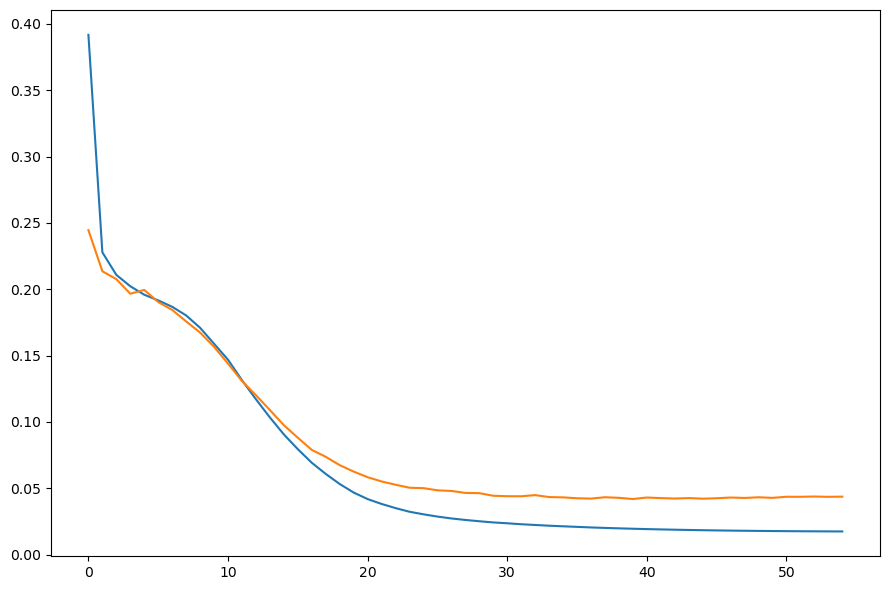

In [19]:
X_test_t = torch.from_numpy(X_test).to(device)
y_test_t = torch.from_numpy(y_test).to(device)

print(X_test_t[0].shape)

plt.figure(figsize=(9,6))
plt.plot(t_loss)
plt.plot(v_loss)
plt.tight_layout()
plt.show()

In [20]:
inference_scheduler = DDIMScheduler.from_config(scheduler.config)
inference_scheduler.config.clip_sample = False

In [ ]:
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model'])

rm_t = []
rm_s = []
cc_list = []
snr7_example = []
snr1_example = []
snr3_example = []
cleans = []
for s in range(11):
    print(f"Testing for SNR: {-7+s}")
    y_ref = y_test_t[s].to(device)
    y_hat = denoise(model, inference_scheduler, X_test_t[s], num_inference_steps=50, batch_size=128)
    if s == 0:
        snr7_example.append(y_hat)
    cleans.append(y_test_t[0])
    y_hat = y_hat.to(device)
    m = rrmse_time(y_hat, y_ref)
    sp = rrmse_spectral(y_hat, y_ref)
    c = cc(y_hat, y_ref)
    print(f"RRMSE_t={m:.4f}, RRMSE_s={sp:.4f} CC={c:.4f}")
    rm_t.append(m)
    rm_s.append(sp)
    cc_list.append(c)


Testing for SNR: -7
RRMSE_t=0.2510, RRMSE_s=0.1657 CC=0.9447
Testing for SNR: -6
RRMSE_t=0.2263, RRMSE_s=0.1516 CC=0.9577
Testing for SNR: -5
RRMSE_t=0.2081, RRMSE_s=0.1409 CC=0.9663
Testing for SNR: -4
RRMSE_t=0.1958, RRMSE_s=0.1335 CC=0.9714
Testing for SNR: -3
RRMSE_t=0.1865, RRMSE_s=0.1277 CC=0.9749
Testing for SNR: -2
RRMSE_t=0.1800, RRMSE_s=0.1236 CC=0.9770
Testing for SNR: -1
RRMSE_t=0.1747, RRMSE_s=0.1201 CC=0.9786
Testing for SNR: 0
RRMSE_t=0.1709, RRMSE_s=0.1176 CC=0.9795
Testing for SNR: 1
RRMSE_t=0.1679, RRMSE_s=0.1156 CC=0.9802
Testing for SNR: 2
RRMSE_t=0.1655, RRMSE_s=0.1140 CC=0.9808
Testing for SNR: 3
RRMSE_t=0.1637, RRMSE_s=0.1128 CC=0.9812


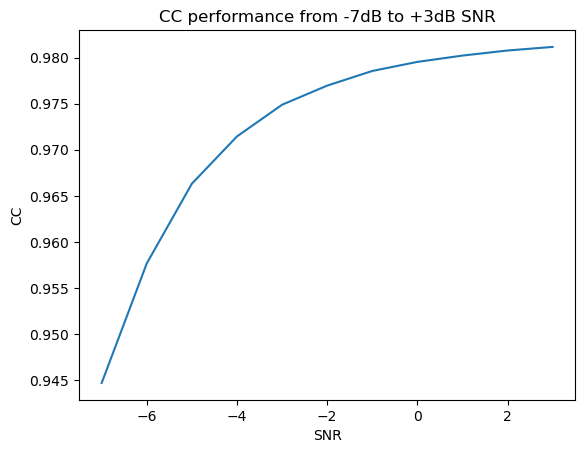

In [43]:
snr_list = np.arange(-7,4)
plt.title("CC performance from -7dB to +3dB SNR")
plt.xlabel("SNR" )
plt.ylabel("CC")
plt.plot(snr_list, cc_list)

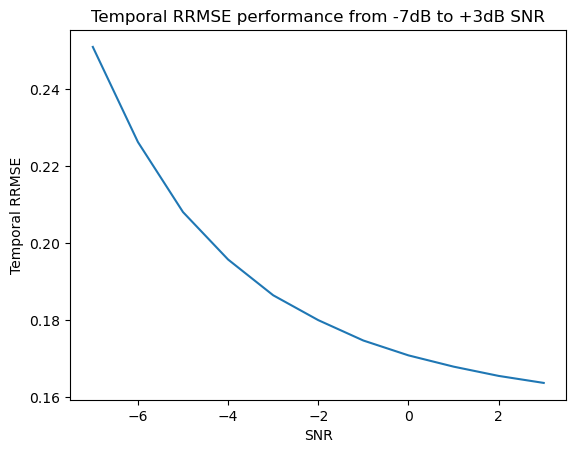

In [ ]:
plt.title("Temporal RRMSE performance from -7dB to +3dB SNR")
plt.xlabel("SNR" )
plt.ylabel("Temporal RRMSE")
plt.plot(snr_list,rm_t)

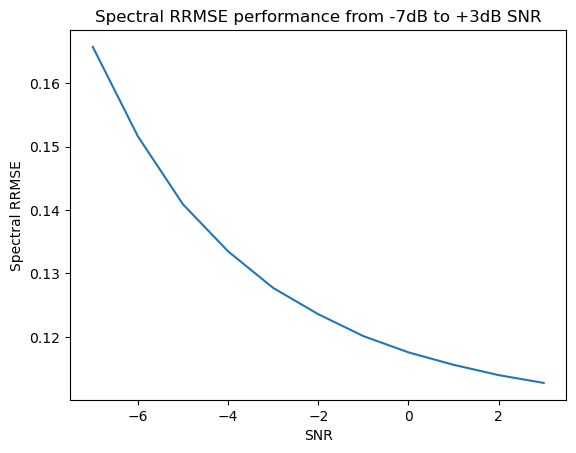

In [45]:
plt.title("Spectral RRMSE performance from -7dB to +3dB SNR")
plt.xlabel("SNR" )
plt.ylabel("Spectral RRMSE")
plt.plot(snr_list,rm_s)

In [24]:
def take_1d(x):
    if isinstance(x, list):
        x = x[0]
    if torch.is_tensor(x):
        x = x.detach().cpu()
    if x.ndim == 3: 
        x = x[0, 0]
    elif x.ndim == 2:
        x = x[0]
    return x.numpy()

In [25]:
denoised_plot_7 = take_1d(snr7_example[0])
clean_plot    = take_1d(y_test_t[0])

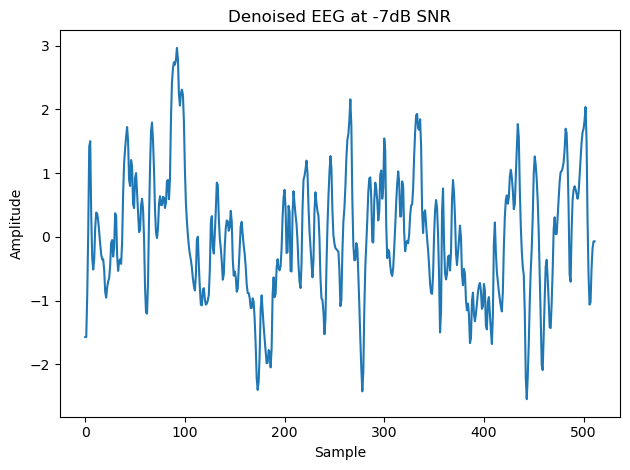

In [26]:
plt.plot(denoised_plot_7)
plt.title("Denoised EEG at -7dB SNR")
plt.xlabel("Sample" )
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

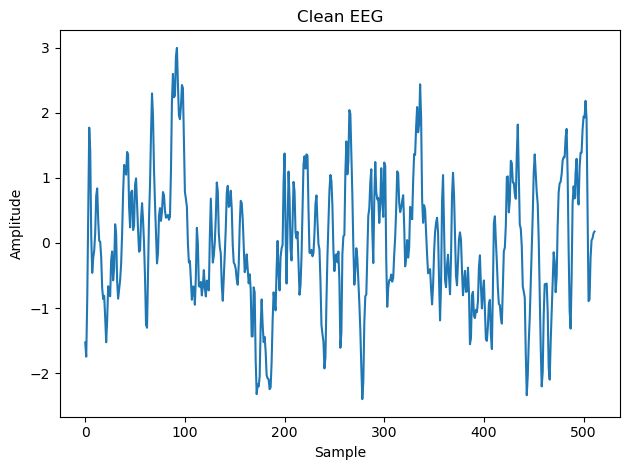

In [27]:
plt.plot(clean_plot)
plt.title("Clean EEG")
plt.xlabel("Sample" )
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

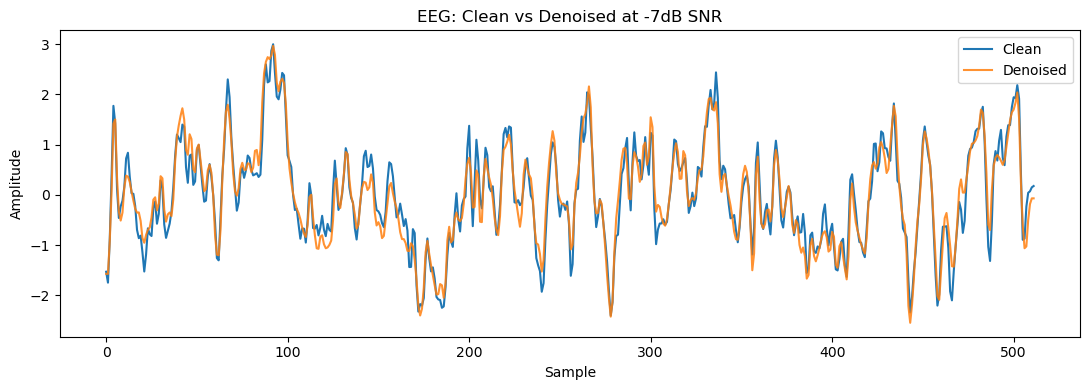

In [28]:
plt.figure(figsize=(11, 4))
plt.plot(clean_plot, label="Clean")
plt.plot(denoised_plot_7, label="Denoised", alpha=0.85)
plt.title("EEG: Clean vs Denoised at -7dB SNR")
plt.xlabel("Sample" )
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()

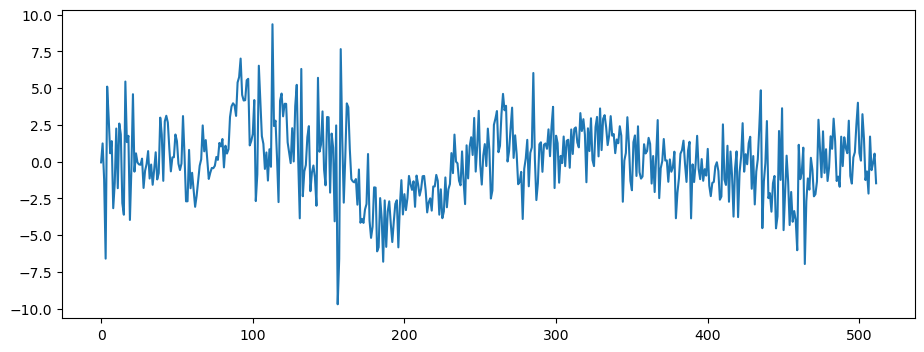

In [29]:
plt.figure(figsize=(11, 4))
plt.plot(X_test[0][0][0])

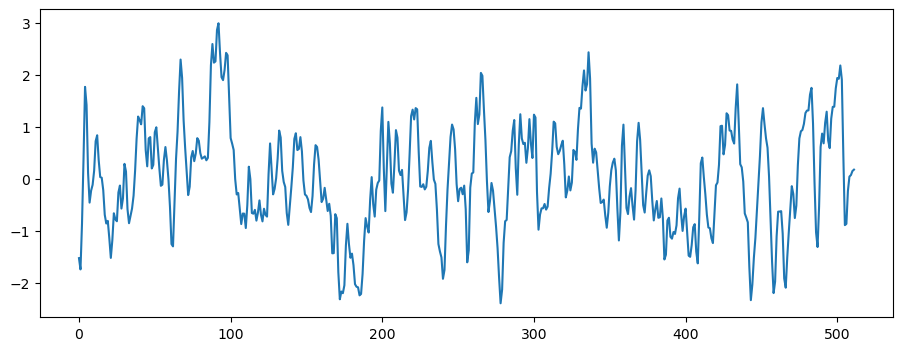

In [39]:
plt.figure(figsize=(11, 4))
plt.plot(y_test[0][0][0])

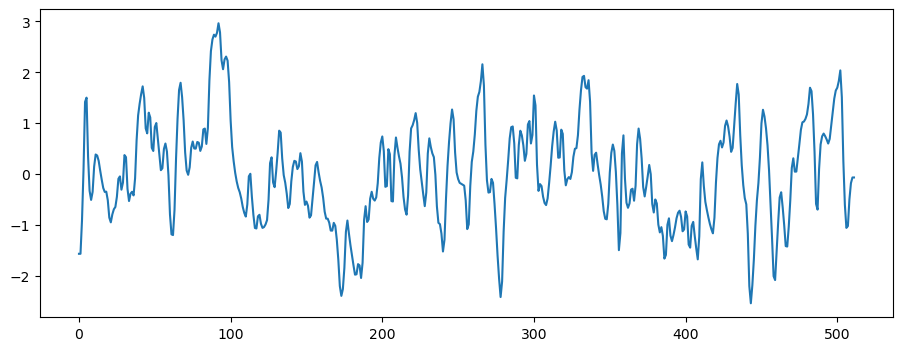

In [32]:
plt.figure(figsize=(11, 4))
plt.plot(denoised_plot_7)

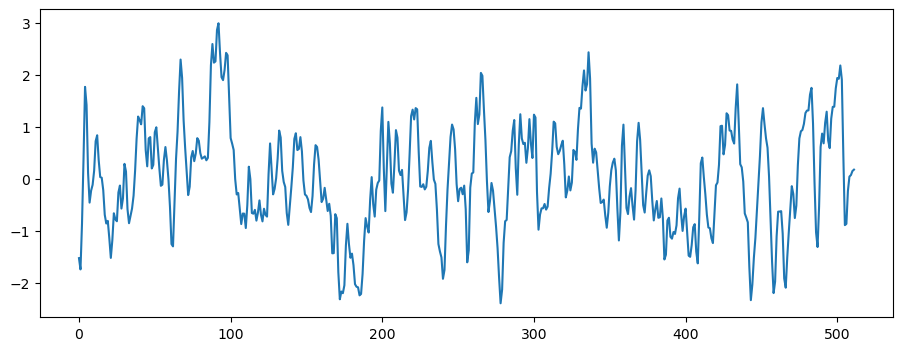

In [38]:
plt.figure(figsize=(11, 4))
plt.plot(y_test[0][0][0])

In [41]:
np.save("save_data/X_train.npy", X_train)
np.save("save_data/y_train.npy", y_train)
np.save("save_data/X_val.npy", X_val)
np.save("save_data/y_val.npy", y_val)
np.save("save_data/X_test.npy",  X_test)
np.save("save_data/y_test.npy",  y_test)